In [1]:
import os
import pandas as pd
import numpy as np
import csv
from collections import defaultdict
import urllib
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import gffpandas.gffpandas as gffpd  
from pyfaidx import Fasta
from Bio import SeqIO
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
from scipy.stats import ranksums
from scipy.stats import mannwhitneyu  
import scipy

species_names = [
 'Acidomyces_richmondensis',
 'Acidomyces_sp',
 'Alternaria_alternata',
 'Ascoidea_rubescens',
 'Aspergillus_brasiliensis',
 'Aspergillus_candidus',
 'Aspergillus_carbonarius',
 'Aspergillus_glaucus',
 'Aspergillus_luchuensis',
 'Aspergillus_novofumigatus',
 'Aspergillus_ochraceoroseus',
 'Aspergillus_sydowi',
 'Aspergillus_tubingensis',
 'Aspergillus_versicolor',
 'Aspergillus_wentii',
 'Babjeviella_inositovora',
 'Coniochaeta_ligniaria',
 'Cyberlindnera_jadinii',
 'Daldinia_sp',
 'Hyphopichia_burtonii',
 'Hypoxylon_sp',
 'Metschnikowia_bicuspidata',
 'Microdochium_bolley',
 'Nadsonia_fulvescens',
 'Paraphaeosphaeria_sporulosa',
 'Penicilliopsis_zonata',
 'Phialocephala_scopiformis',
 'Pseudomassariella_vexata',
 'Pyrenochaeta_sp',
 'Saccharomyces_cerevisiae',
 'Stagonospora_sp',
 'Suhomyces_tanzawaensis',
 'Xylona_heveae']
    
print(scipy.__version__)


2024-04-26 11:28:01.174197: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-26 11:28:01.446156: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 11:28:01.446275: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 11:28:01.492110: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-26 11:28:01.591218: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-26 11:28:01.592641: I tensorflow/core/platform/cpu_feature_guard.cc:1

1.12.0


In [2]:
# Define the directory path
directory_path = "Dataset_Assembly/Species_data/species_gff3_dataframes"

# Sort species names alphabetically
sorted_species_names = sorted(species_names)

# Initialize an empty list to store the loaded DataFrames
species_dataframes = []

# Iterate over each species name and corresponding file
for species_name in sorted_species_names:
    file_name = f"{species_name}.csv"
    file_path = os.path.join(directory_path, file_name)
    
    # Load the DataFrame from the CSV file
    df = pd.read_csv(file_path)
    
    # Append the DataFrame to the list
    species_dataframes.append(df)

# Display the loaded DataFrames
#for i, df in enumerate(species_dataframes):
    #print(f"DataFrame for {sorted_species_names[i]}:")
    #print(df)


In [3]:
# Define the directory path
directory_path = "Dataset_Assembly/Species_data/species_all_orf_seqs"

# Sort species names alphabetically
sorted_species_names = sorted(species_names)

# Initialize an empty list to store the loaded DataFrames
all_orf_seqs = []

# Iterate over each species name and corresponding file
for species_name in sorted_species_names:
    file_name = f"{species_name}_orf_seqs.csv"
    file_path = os.path.join(directory_path, file_name)
    #print(f"Processing species: {species_name}")
    # Load the DataFrame from the CSV file
    df = pd.read_csv(file_path)
    
    # Append the DataFrame to the list
    all_orf_seqs.append(df)




In [4]:
#GC content
def calculate_gc_content(sequence):
    gc_count = sequence.count('G') + sequence.count('C')
    total_bases = len(sequence)
    if total_bases == 0:
        return 0
    return (gc_count / total_bases) * 100


In [5]:

gc_contents = []  # To store average GC content for each species and region
for i, df in enumerate(all_orf_seqs):
    # Print the species name corresponding to the dataframe being processed
    #print(f"Processing species: {species_names[i]}")
    
    gc_content_species = {
        'prom': np.mean([calculate_gc_content(str(seq)) for seq in df['prom']]),
        '5UTR': np.mean([calculate_gc_content(str(seq)) for seq in df['5UTR']]),
        '3UTR': np.mean([calculate_gc_content(str(seq)) for seq in df['3UTR']]),
        'term': np.mean([calculate_gc_content(str(seq)) for seq in df['term']])
    }
    gc_contents.append(gc_content_species)





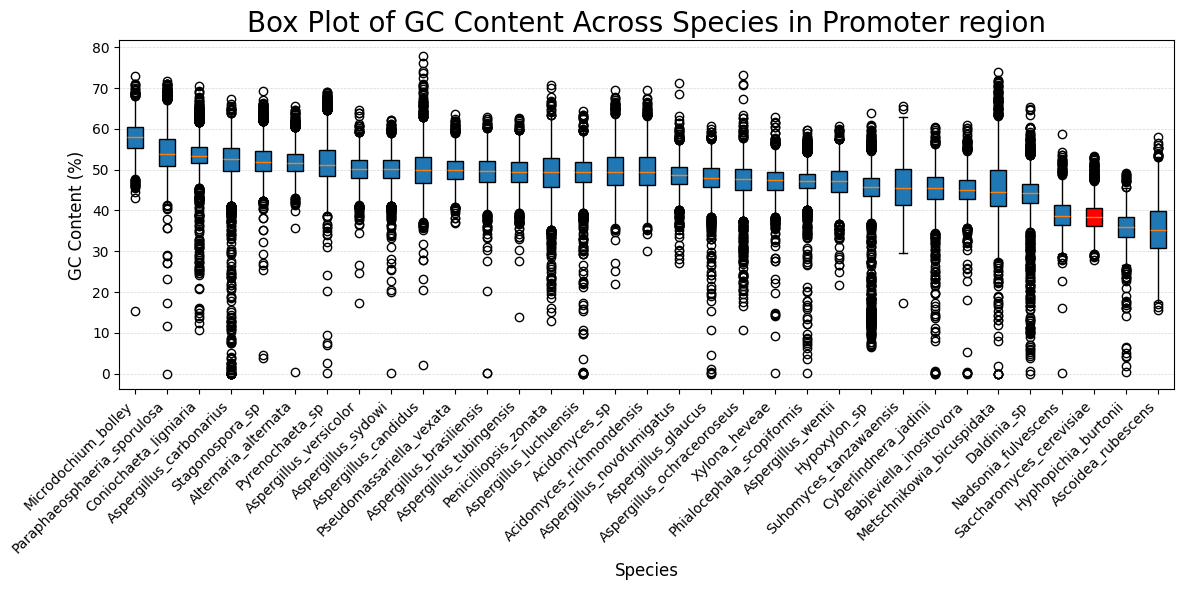

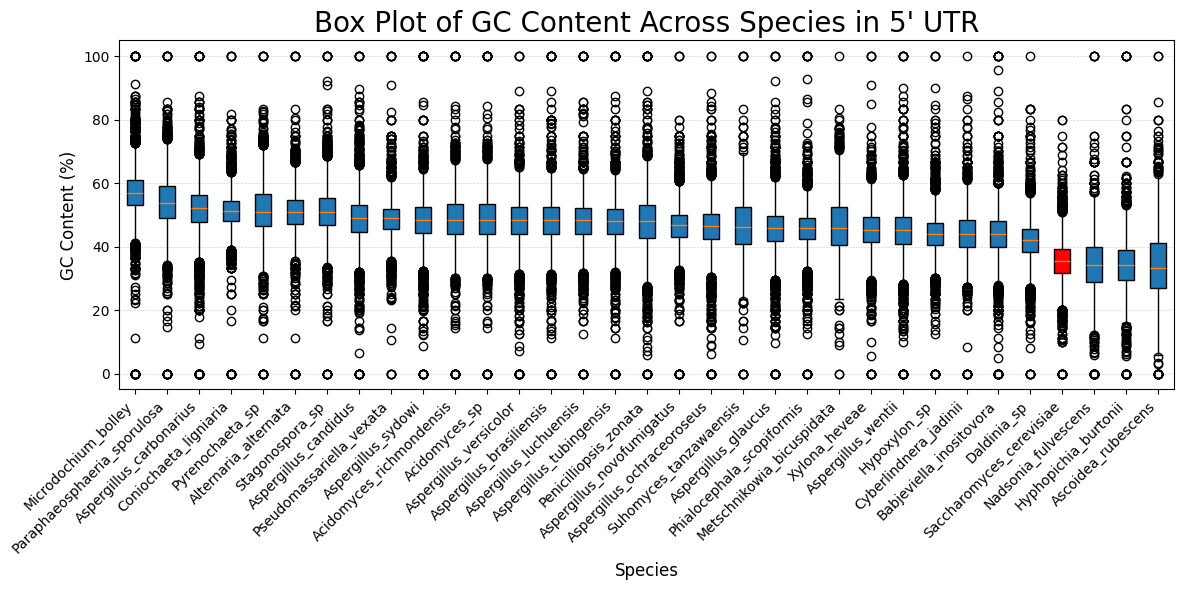

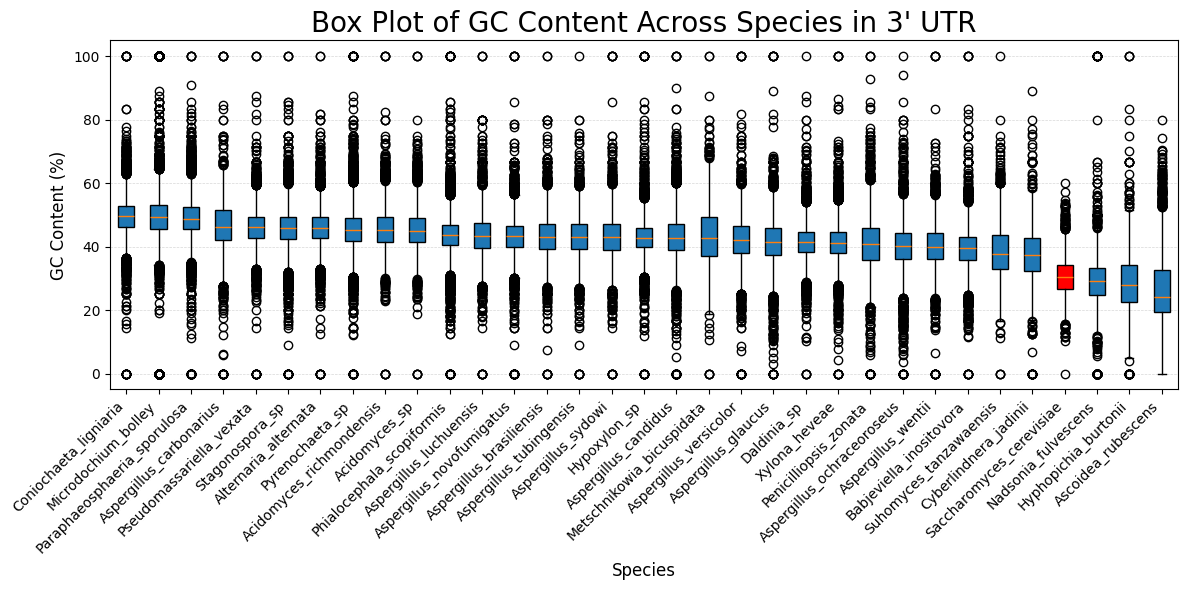

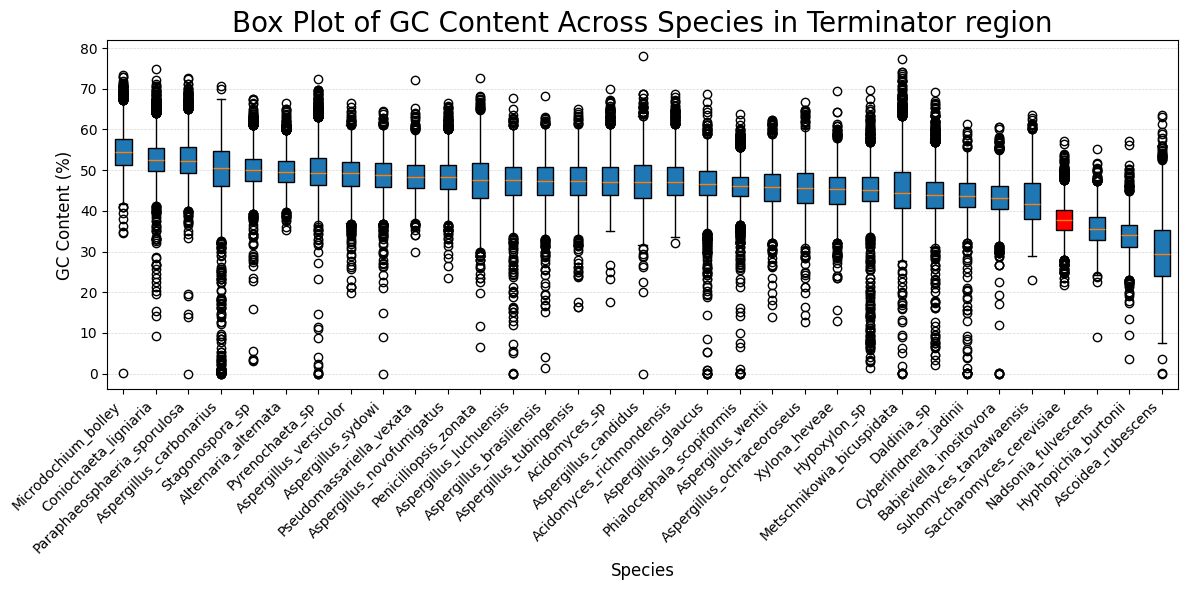

In [6]:
# Adapted for box plot visualisation with sorting by median values
gc_content_data = {'prom': [], '5UTR': [], '3UTR': [], 'term': []}

# Mapping region codes to full names for titles
region_titles = {
    'prom': 'Promoter region',
    '5UTR': "5' UTR",
    '3UTR': "3' UTR",
    'term': 'Terminator region'
}

for i, df in enumerate(all_orf_seqs):
    for region in gc_content_data.keys():
        # Collect all GC content values for each region
        gc_contents = [calculate_gc_content(str(seq)) for seq in df[region]]
        gc_content_data[region].append(gc_contents)

# Now plot box plots for each region, sorted by the median values
for region in gc_content_data.keys():
    plt.figure(figsize=(12, 6))
    
    # Calculate medians for each species in the current region
    medians = [np.median(gc) if len(gc) > 0 else 0 for gc in gc_content_data[region]]
    
    # Sort species by median GC content
    sorted_indices = np.argsort(medians)[::-1]  # Get indices to sort in descending order
    sorted_gc_contents = [gc_content_data[region][index] for index in sorted_indices]
    sorted_labels = [species_names[index] for index in sorted_indices]
    
    # Create a box plot for the current region across all species, sorted by median GC content
    bp = plt.boxplot(sorted_gc_contents, labels=sorted_labels, patch_artist=True)
    
    # Highlight Saccharomyces cerevisiae in red, finding its new index after sorting
    saccharomyces_new_index = sorted_labels.index('Saccharomyces_cerevisiae')
    bp['boxes'][saccharomyces_new_index].set_facecolor('red')
    
    
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5, axis='y')
    
    plt.xlabel('Species', fontsize=12)
    plt.ylabel(f'GC Content (%)', fontsize=12)
    plt.title(f'Box Plot of GC Content Across Species in {region_titles[region]}', fontsize=20)
    plt.xticks(rotation=45, ha="right")  
    
    plt.tight_layout()
    plt.show()


In [7]:
species_5UTR_gc_content = [[] for _ in range(33)]
species_3UTR_gc_content = [[] for _ in range(33)]

# Assuming the calculate_gc_content function is defined as provided

# Initialize the GC content lists for 33 species.
species_5UTR_gc_content = [[] for _ in range(33)]
species_3UTR_gc_content = [[] for _ in range(33)]

for i, df in enumerate(all_orf_seqs):
    # Calculate and collect all GC content values for 5' UTR and 3' UTR for each species
    species_5UTR_gc_content[i] = [calculate_gc_content(str(seq)) for seq in df['5UTR']]
    species_3UTR_gc_content[i] = [calculate_gc_content(str(seq)) for seq in df['3UTR']]




In [8]:
# Initialize the GC content lists for 33 species.
species_5UTR_gc_content = [[] for _ in range(33)]
species_3UTR_gc_content = [[] for _ in range(33)]

# Assuming all_orf_seqs and species_names are defined properly
for i, df in enumerate(all_orf_seqs):
    species_5UTR_gc_content[i] = [calculate_gc_content(str(seq)) for seq in df['5UTR']]
    species_3UTR_gc_content[i] = [calculate_gc_content(str(seq)) for seq in df['3UTR']]

# Index for Saccharomyces cerevisiae
saccharomyces_index = 29  # Adjusted for zero-indexing
n_comparisons = len(species_names) - 1  # Exclude Saccharomyces cerevisiae for Bonferroni correction

# Perform Wilcoxon rank sum tests against Saccharomyces cerevisiae for all species

p_values_5UTR = []
p_values_3UTR = []
for i in range(33):
    if i != saccharomyces_index:  # Skip the comparison for Saccharomyces cerevisiae itself
        _, p_value_5utr = ranksums(species_5UTR_gc_content[saccharomyces_index], species_5UTR_gc_content[i])
        _, p_value_3utr = ranksums(species_3UTR_gc_content[saccharomyces_index], species_3UTR_gc_content[i])
        # Apply Bonferroni correction
        p_value_5utr_corrected = min(p_value_5utr * n_comparisons, 1)
        p_value_3utr_corrected = min(p_value_3utr * n_comparisons, 1)
        p_values_5UTR.append(p_value_5utr_corrected)
        p_values_3UTR.append(p_value_3utr_corrected)

# Now p_values_5UTR and p_values_3UTR lists both contain 32 values as expected

# Negative log of the corrected P-values to plot
neg_log_p_values_5UTR = -np.log10(p_values_5UTR)
neg_log_p_values_3UTR = -np.log10(p_values_3UTR)

# Handling NaN values safely for bar chart
neg_log_p_values_5UTR = [x if not np.isnan(x) else 0 for x in neg_log_p_values_5UTR]
neg_log_p_values_3UTR = [x if not np.isnan(x) else 0 for x in neg_log_p_values_3UTR]



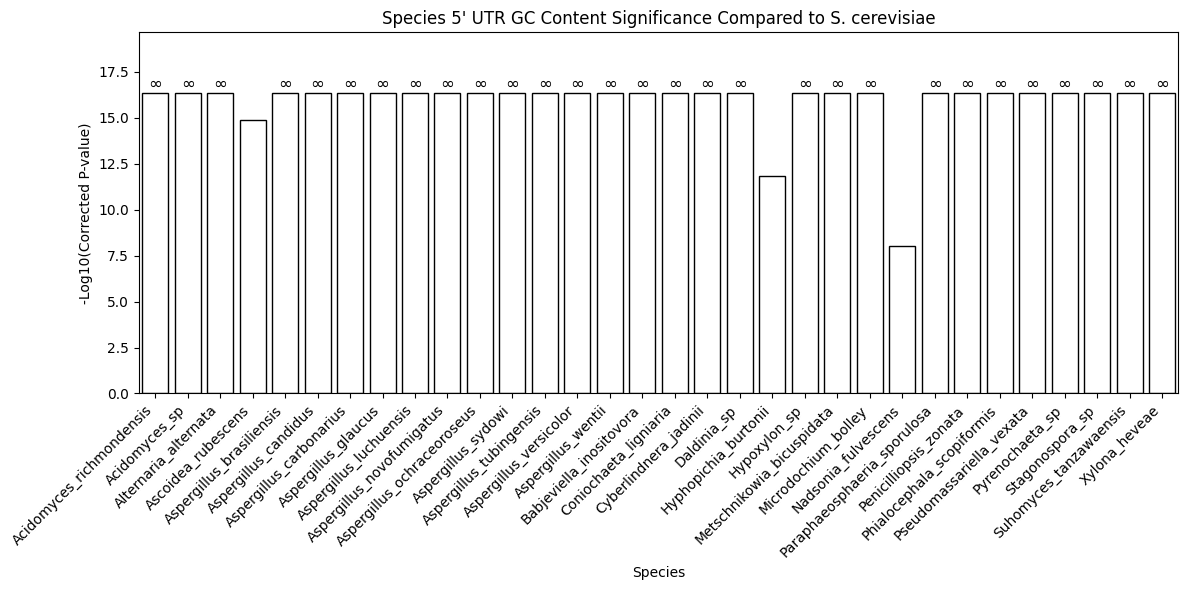

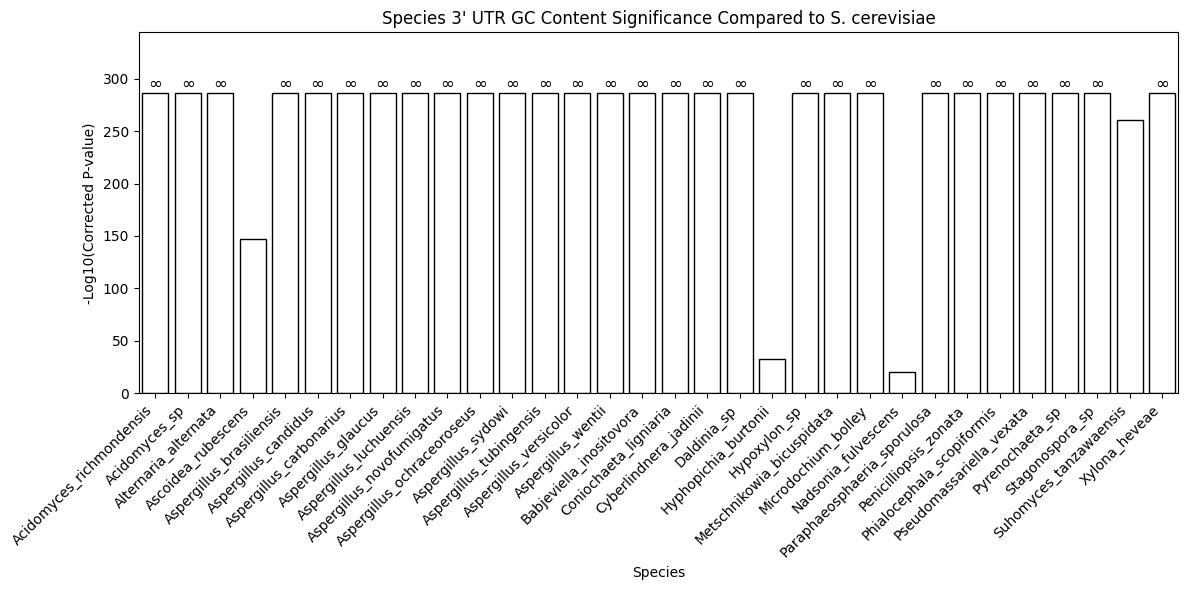

In [9]:
# Plotting to show significance
temp_species_names = [species for i, species in enumerate(species_names) if i != 29]
def plot_significance(species_names, neg_log_p_values, title):
    finite_values = [value for value in neg_log_p_values if value != np.inf]
    max_finite_value = max(finite_values) if finite_values else 100
    high_value = max_finite_value * 1.1
    adjusted_values = [value if value != np.inf else high_value for value in neg_log_p_values]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(species_names)), adjusted_values, color='white', edgecolor='black')
    for i, value in enumerate(neg_log_p_values):
        if value == np.inf:
            plt.text(i, high_value, '∞', ha='center', va='bottom', color='black', fontsize=12)

    plt.xticks(range(len(species_names)), species_names, rotation=45, ha="right")
    plt.xlabel('Species')
    plt.ylabel('-Log10(Corrected P-value)')
    plt.title(title)
    plt.ylim(0, high_value * 1.2)
    plt.xlim([-0.5, len(species_names)-0.5]) 
    plt.tight_layout()
    plt.show()


plot_significance(temp_species_names, neg_log_p_values_5UTR, "Species 5' UTR GC Content Significance Compared to S. cerevisiae")
plot_significance(temp_species_names, neg_log_p_values_3UTR, "Species 3' UTR GC Content Significance Compared to S. cerevisiae")


In [10]:
# Initialize lists to store average and median lengths for 5' UTR and 3' UTR regions
average_5utr_lengths = []
median_5utr_lengths = []
average_3utr_lengths = []
median_3utr_lengths = []

# Use zip to iterate over both dataframes and their corresponding species names simultaneously
for df, species_name in zip(species_dataframes, species_names):
    # Calculate the average (mean) lengths
    average_5utr = df['5utr_len'].mean()
    average_3utr = df['3utr_len'].mean()

    # Calculate the median lengths
    median_5utr = df['5utr_len'].median()
    median_3utr = df['3utr_len'].median()

    # Append the averages and medians to their respective lists
    average_5utr_lengths.append(average_5utr)
    median_5utr_lengths.append(median_5utr)
    average_3utr_lengths.append(average_3utr)
    median_3utr_lengths.append(median_3utr)

    # Print the species name along with the average and median 5' UTR and 3' UTR lengths
    print(f"Processing {species_name}")
    print(f"{species_name}: Average 5' UTR Length = {average_5utr}, Median 5' UTR Length = {median_5utr}")
    print(f"{species_name}: Average 3' UTR Length = {average_3utr}, Median 3' UTR Length = {median_3utr}\n")

# The order of lengths remains consistent with the input dataframes and species names.


Processing Acidomyces_richmondensis
Acidomyces_richmondensis: Average 5' UTR Length = 171.78708668453976, Median 5' UTR Length = 143.0
Acidomyces_richmondensis: Average 3' UTR Length = 209.13069705093835, Median 3' UTR Length = 190.0

Processing Acidomyces_sp
Acidomyces_sp: Average 5' UTR Length = 175.65544602067806, Median 5' UTR Length = 148.0
Acidomyces_sp: Average 3' UTR Length = 212.75763404664582, Median 3' UTR Length = 195.0

Processing Alternaria_alternata
Alternaria_alternata: Average 5' UTR Length = 208.79059544425203, Median 5' UTR Length = 192.0
Alternaria_alternata: Average 3' UTR Length = 190.34567736779007, Median 3' UTR Length = 167.0

Processing Ascoidea_rubescens
Ascoidea_rubescens: Average 5' UTR Length = 170.18691263487645, Median 5' UTR Length = 139.0
Ascoidea_rubescens: Average 3' UTR Length = 179.85207100591717, Median 3' UTR Length = 155.0

Processing Aspergillus_brasiliensis
Aspergillus_brasiliensis: Average 5' UTR Length = 181.3405017921147, Median 5' UTR Leng

In [11]:
utr_5_lengths = []
utr_3_lengths = []

# Assuming each dataframe in species_dataframes has 'len_5u' and 'len_3u' columns
for df in species_dataframes:
    # Collect the lengths from 'len_5u' and 'len_3u' columns, assuming they don't contain missing values
    # If they might contain NaNs, consider using .dropna() as shown below
    utr_5_lengths.append(df['5utr_len'].dropna().values)  # Extracting 5' UTR lengths
    utr_3_lengths.append(df['3utr_len'].dropna().values)  # Extracting 3' UTR lengths

# Now that utr_5_lengths and utr_3_lengths are defined, you can use the custom_boxplot function as intended


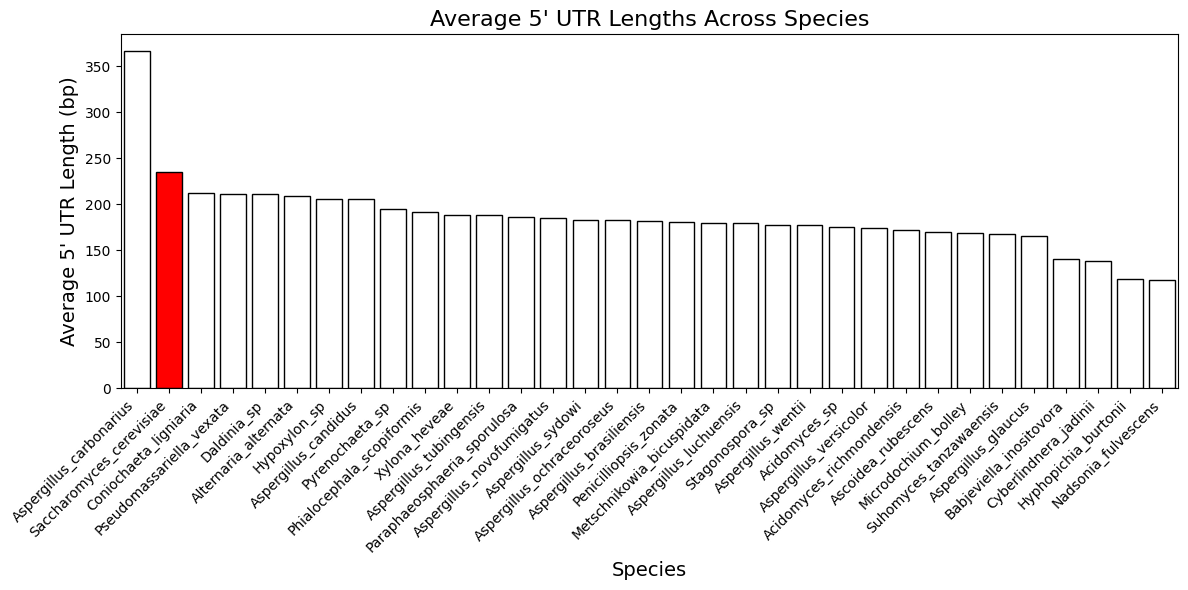

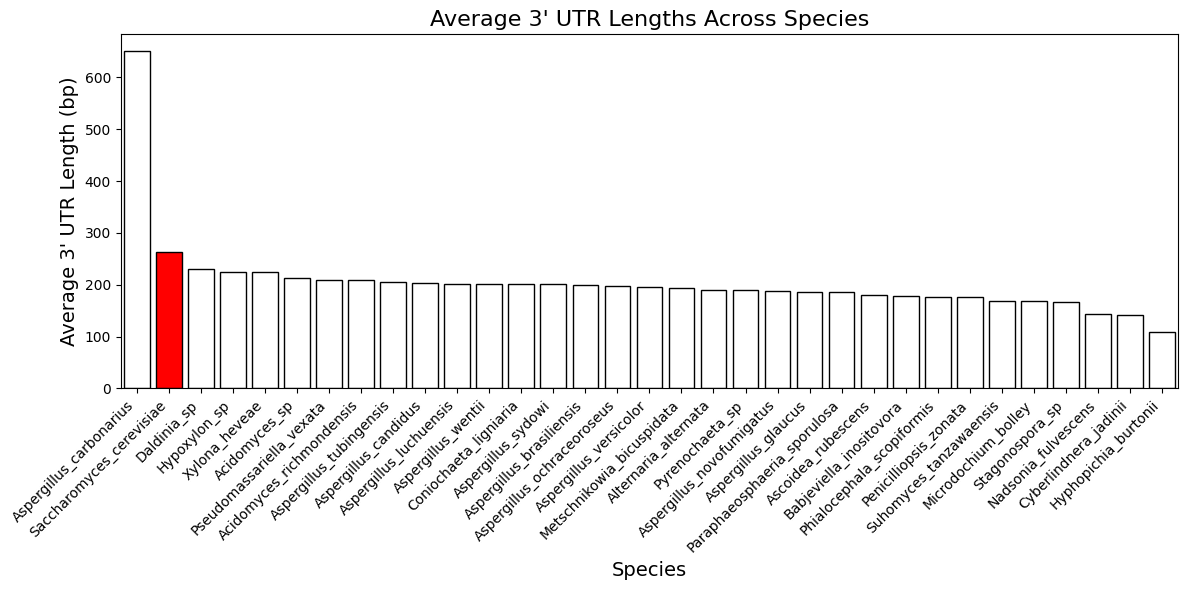

In [12]:


# Combine both 5' and 3' UTR lengths with species names, then sort by 5' UTR lengths
sorted_5utr_data = sorted(zip(species_names, average_5utr_lengths), key=lambda x: x[1], reverse=True)
sorted_3utr_data = sorted(zip(species_names, average_3utr_lengths), key=lambda x: x[1], reverse=True)

# Extract sorted names and lengths for 5' UTR
sorted_species_names_5utr, sorted_avg_5utr_lengths = zip(*sorted_5utr_data)
# Extract sorted names and lengths for 3' UTR
sorted_species_names_3utr, sorted_avg_3utr_lengths = zip(*sorted_3utr_data)

# Plotting average 5' UTR lengths in descending order, highlighting Saccharomyces cerevisiae in red
plt.figure(figsize=(12, 6))
for i, (species_name, length) in enumerate(zip(sorted_species_names_5utr, sorted_avg_5utr_lengths)):
    color = 'red' if species_name == 'Saccharomyces_cerevisiae' else 'white'
    plt.bar(i, length, color=color, edgecolor='black', align='center')
plt.xlabel('Species', fontsize=14)
plt.ylabel('Average 5\' UTR Length (bp)', fontsize=14)
plt.xticks(range(len(sorted_species_names_5utr)), sorted_species_names_5utr, rotation=45, ha="right")
plt.title('Average 5\' UTR Lengths Across Species', fontsize=16)
plt.xlim([-0.5, len(species_names)-0.5]) 
plt.tight_layout()



plt.show()

# Plotting average 3' UTR lengths in descending order, highlighting Saccharomyces cerevisiae in red
plt.figure(figsize=(12, 6))
for i, (species_name, length) in enumerate(zip(sorted_species_names_3utr, sorted_avg_3utr_lengths)):
    color = 'red' if species_name == 'Saccharomyces_cerevisiae' else 'white'
    plt.bar(i, length, color=color, edgecolor='black', align='center')
plt.xlabel('Species', fontsize=14)
plt.ylabel('Average 3\' UTR Length (bp)', fontsize=14)
plt.xticks(range(len(sorted_species_names_3utr)), sorted_species_names_3utr, rotation=45, ha="right")
plt.title('Average 3\' UTR Lengths Across Species', fontsize=16)
plt.xlim([-0.5, len(species_names)-0.5])  
plt.tight_layout()
plt.show()


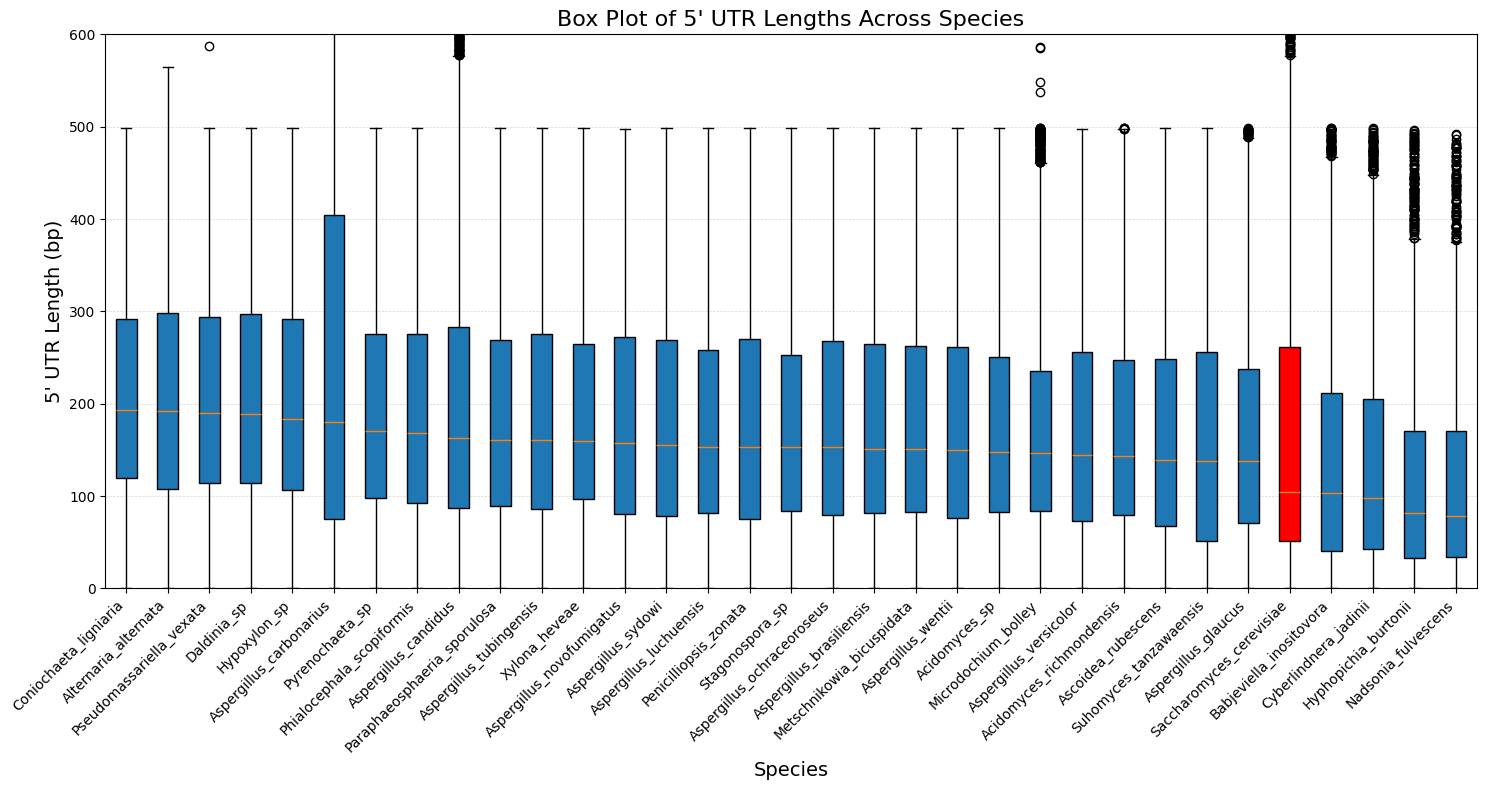

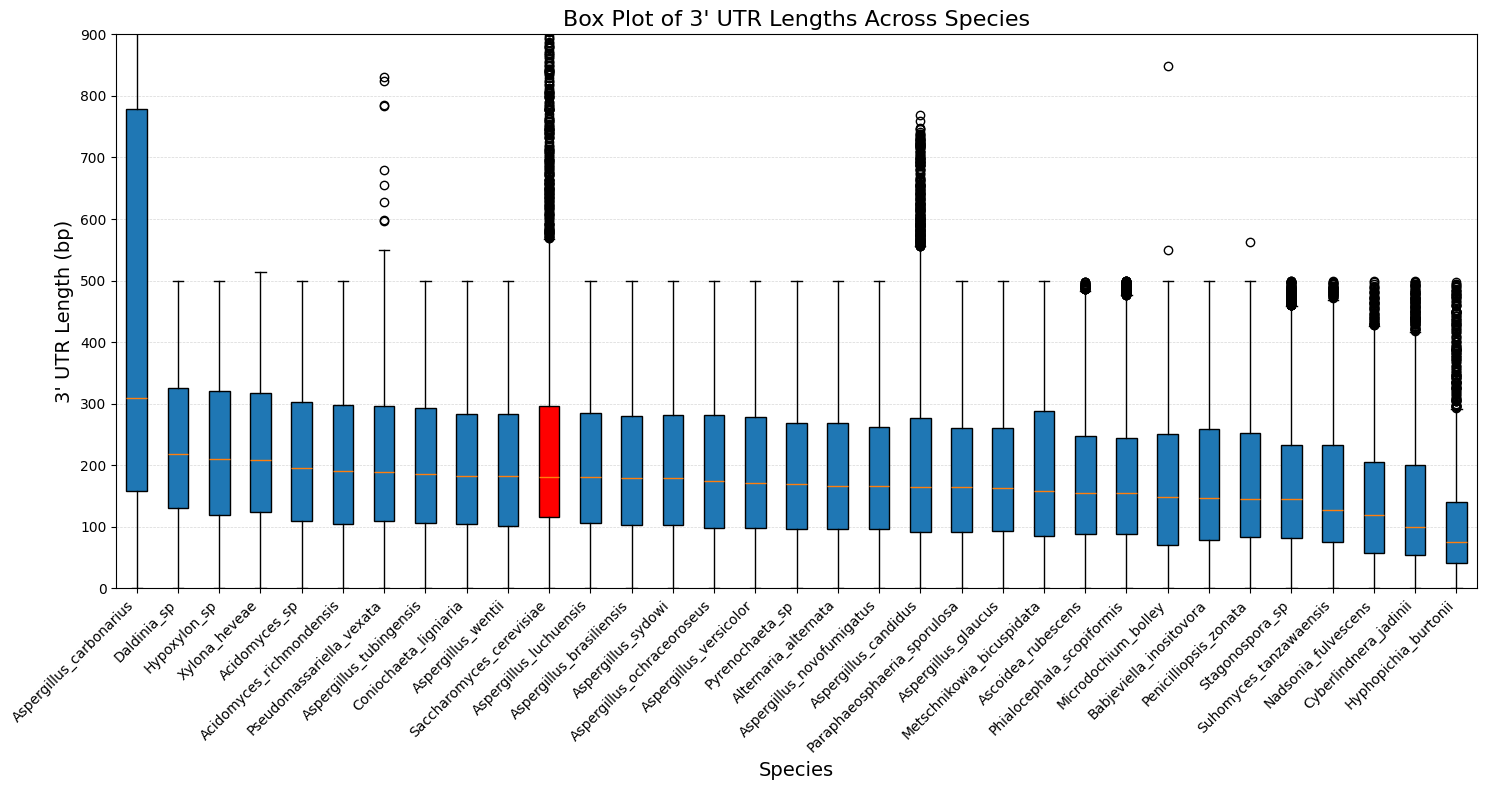

In [13]:

def custom_boxplot(data, labels, title, ylabel, highlight_name, ylim=None, save_path=None):
    # Calculate the medians and sort by them
    medians = [np.median(d) if len(d) > 0 else 0 for d in data]  # handle empty data
    sorted_indices = np.argsort(medians)[::-1]  # descending sort
    sorted_data = [data[idx] for idx in sorted_indices]
    sorted_labels = [labels[idx] for idx in sorted_indices]
    
    # Find the index for Saccharomyces cerevisiae after sorting
    highlight_index = sorted_labels.index(highlight_name)
    
    # Create the boxplot
    fig, ax = plt.subplots(figsize=(15, 8))
    bp = ax.boxplot(sorted_data, patch_artist=True, labels=sorted_labels)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.xlabel('Species', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16)
    
    # Set box colors
    for i, box in enumerate(bp['boxes']):
        if i == highlight_index:
            box.set(facecolor='red', edgecolor='black')
        else:
            box.set(edgecolor='black')

    
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    if ylim:
        plt.ylim(0, ylim)
    
    plt.tight_layout()
    plt.show()

# Use the function to plot the boxplots 
saccharomyces_name = 'Saccharomyces_cerevisiae'
custom_boxplot(utr_5_lengths, species_names, 'Box Plot of 5\' UTR Lengths Across Species', '5\' UTR Length (bp)', saccharomyces_name, ylim=600, save_path='Figures/Figure_5a.pdf')
custom_boxplot(utr_3_lengths, species_names, 'Box Plot of 3\' UTR Lengths Across Species', '3\' UTR Length (bp)', saccharomyces_name, ylim=900, save_path='Figures/Figure_5b.pdf')


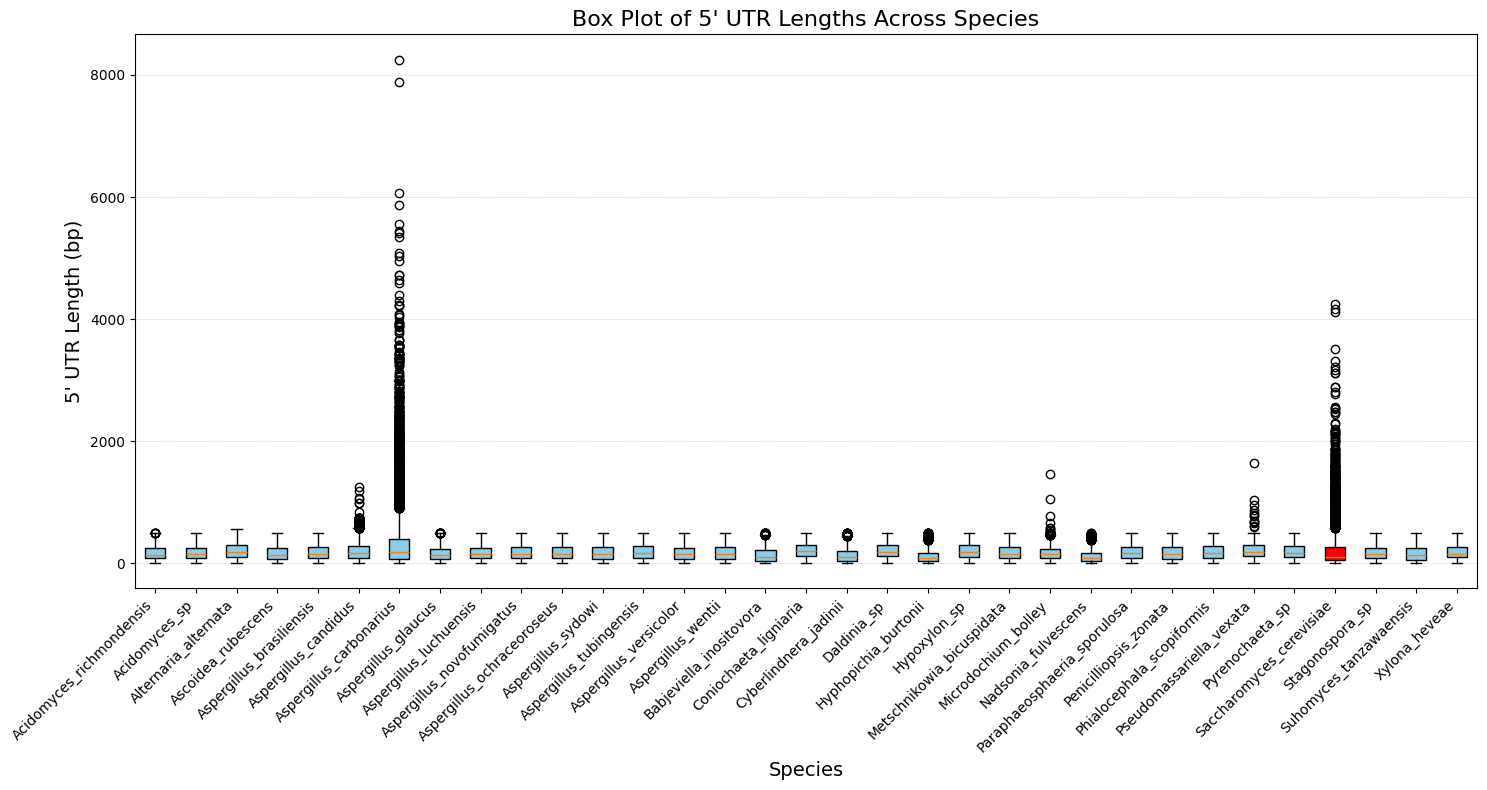

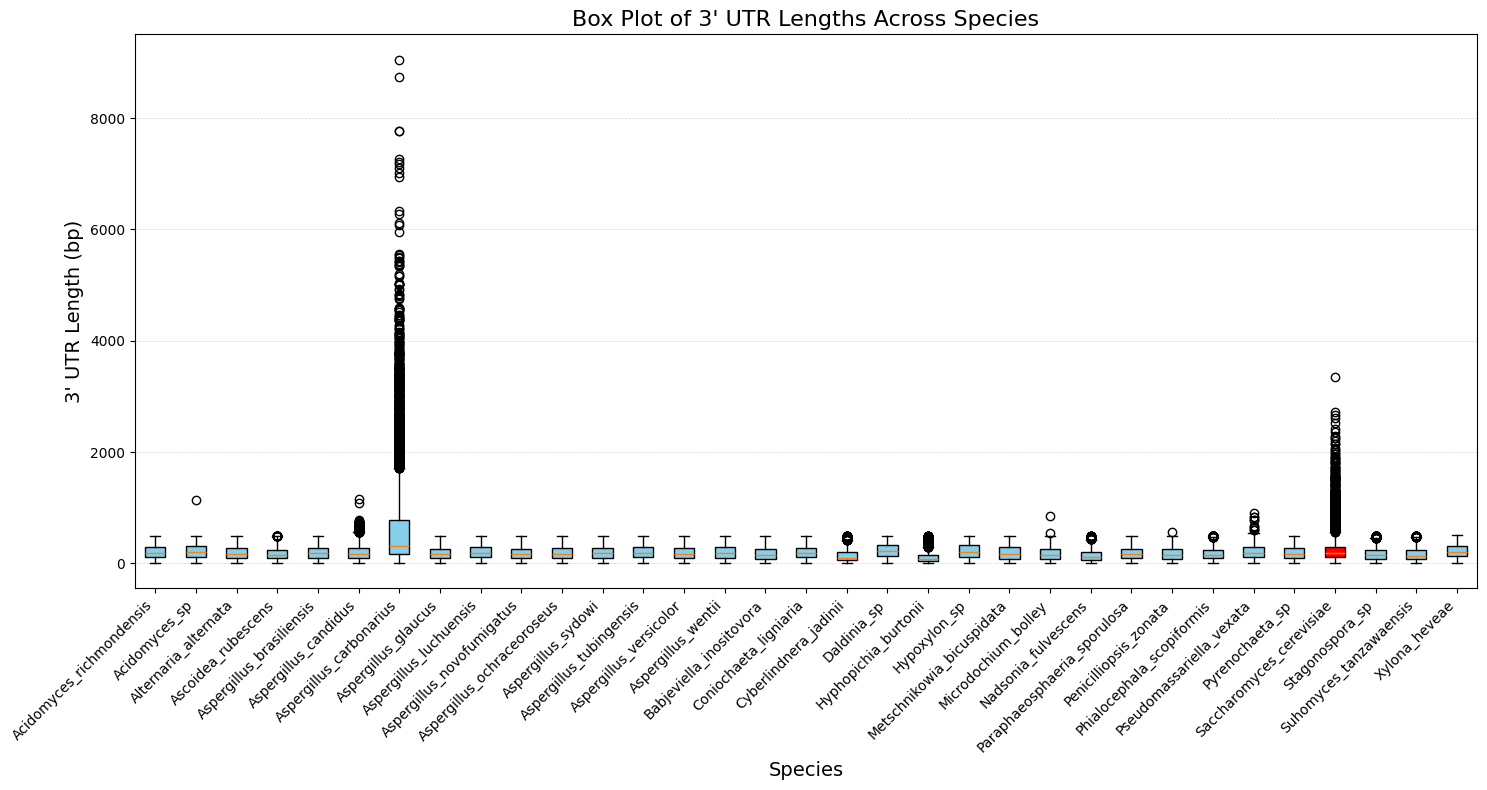

In [14]:


# Function to customize box colors, add grid lines, and label the x-axis
def custom_boxplot(data, labels, title, ylabel, highlight_index):
    fig, ax = plt.subplots(figsize=(15, 8))
    bp = ax.boxplot(data, patch_artist=True, labels=labels)  
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.xlabel('Species', fontsize=14)  
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16)

    # Set colors for each box, highlighting Saccharomyces cerevisiae in red
    for i, box in enumerate(bp['boxes']):
        if i == highlight_index:  
            box.set_facecolor('red')
        else:
            box.set_facecolor('skyblue')  
    
    
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    
    plt.tight_layout()
    plt.show()


saccharomyces_index = species_names.index('Saccharomyces_cerevisiae')

# Plotting box plot for 5' UTR lengths 
custom_boxplot(utr_5_lengths, species_names, 'Box Plot of 5\' UTR Lengths Across Species', 
               '5\' UTR Length (bp)', saccharomyces_index)

# Plotting box plot for 3' UTR lengths
custom_boxplot(utr_3_lengths, species_names, 'Box Plot of 3\' UTR Lengths Across Species', 
               '3\' UTR Length (bp)', saccharomyces_index)


In [17]:


saccharomyces_index = species_names.index('Saccharomyces_cerevisiae')

# Calculate the number of comparisons (for Bonferroni correction)
n_comparisons = len(species_names) - 1  # Exclude Saccharomyces cerevisiae
corrected_p_values_5utr = []
corrected_p_values_3utr = []
# Perform Wilcoxon rank sum tests and apply Bonferroni correction
print("Comparing 5' UTR Lengths:")
for i, species_name in enumerate(species_names):
    if species_name != 'Saccharomyces_cerevisiae':
        stat, p = ranksums(species_dataframes[saccharomyces_index]['5utr_len'].dropna(), 
                           species_dataframes[i]['5utr_len'].dropna())
        p_corrected = min(p * n_comparisons, 1)  # Bonferroni correction
        print(f"{species_name}: p = {p}, Bonferroni corrected p = {p_corrected}")
        corrected_p_values_5utr.append(p_corrected)
print("\nComparing 3' UTR Lengths:")
for i, species_name in enumerate(species_names):
    if species_name != 'Saccharomyces_cerevisiae':
        stat, p = ranksums(species_dataframes[saccharomyces_index]['3utr_len'].dropna(), 
                           species_dataframes[i]['3utr_len'].dropna())
        p_corrected = min(p * n_comparisons, 1)  # Bonferroni correction
        print(f"{species_name}: p = {p}, Bonferroni corrected p = {p_corrected}")
        corrected_p_values_3utr.append(p_corrected)



Comparing 5' UTR Lengths:
Acidomyces_richmondensis: p = 1.235451630662608e-13, Bonferroni corrected p = 3.953445218120345e-12
Acidomyces_sp: p = 1.8661120174959434e-18, Bonferroni corrected p = 5.971558455987019e-17
Alternaria_alternata: p = 2.925954755900671e-108, Bonferroni corrected p = 9.363055218882148e-107
Ascoidea_rubescens: p = 8.531409499630696e-06, Bonferroni corrected p = 0.00027300510398818226
Aspergillus_brasiliensis: p = 3.1700836861918632e-24, Bonferroni corrected p = 1.0144267795813962e-22
Aspergillus_candidus: p = 3.2446640290331564e-47, Bonferroni corrected p = 1.03829248929061e-45
Aspergillus_carbonarius: p = 3.3927026698553755e-74, Bonferroni corrected p = 1.0856648543537202e-72
Aspergillus_glaucus: p = 6.421999538047391e-08, Bonferroni corrected p = 2.055039852175165e-06
Aspergillus_luchuensis: p = 1.875926423341292e-24, Bonferroni corrected p = 6.002964554692134e-23
Aspergillus_novofumigatus: p = 1.9863044431282326e-27, Bonferroni corrected p = 6.356174218010344e-

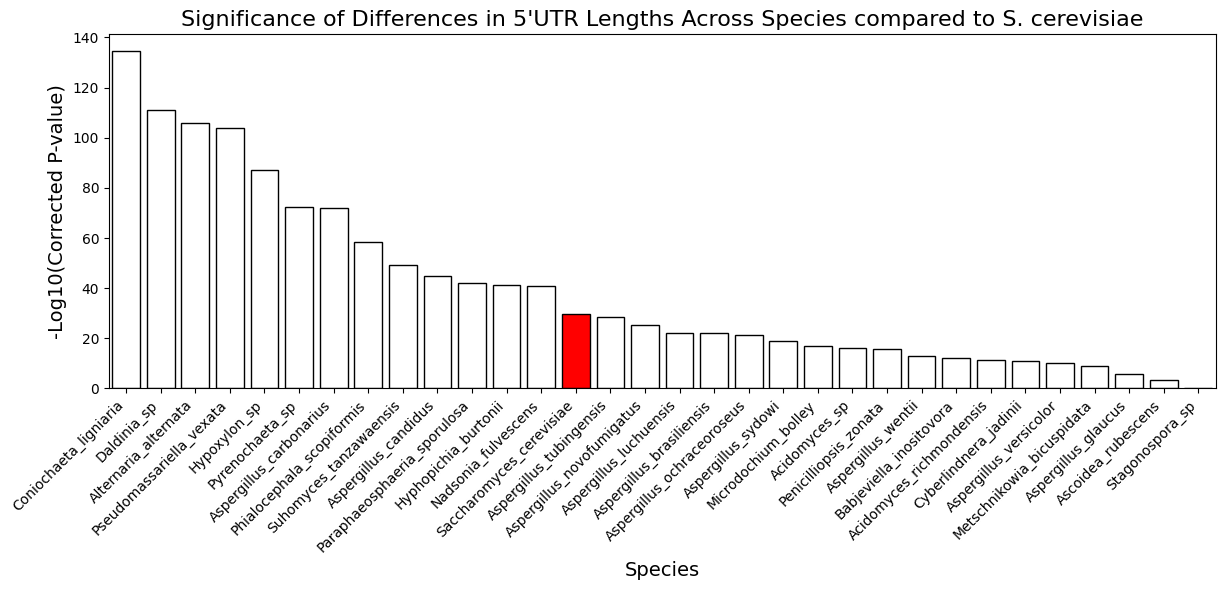

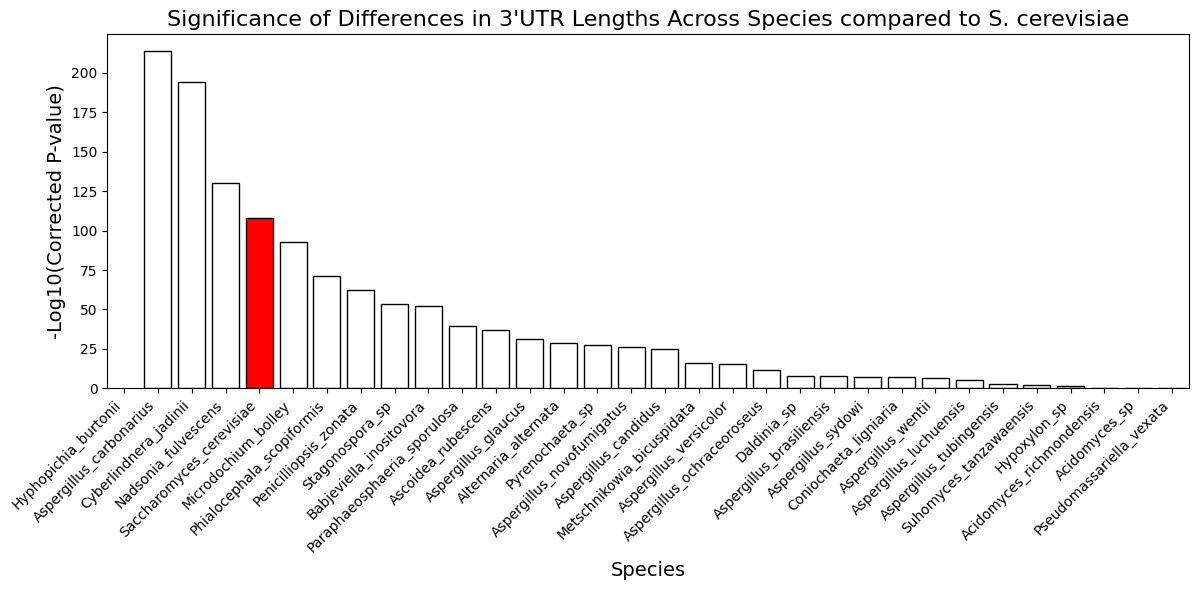

In [19]:


def plot_corrected_p_values(corrected_p_values, species_names, title):
    # Convert p-values to negative logarithm base 10, setting non-significant values (p > 0.05) to 0
    neg_log_p_values = [-np.log10(p) if p <= 0.05 else 0 for p in corrected_p_values]
    
    # Combine neg_log_p_values with species_names and sort by neg_log_p_values in descending order
    combined = list(zip(neg_log_p_values, species_names))
    combined_sorted = sorted(combined, key=lambda x: x[0], reverse=True)
    
    # Unzip the sorted list
    sorted_neg_log_p_values, sorted_species_names = zip(*combined_sorted)
    
   
    colors = ['red' if name == 'Saccharomyces_cerevisiae' else 'white' for name in sorted_species_names]
    edge_colors = ['black' for _ in sorted_species_names]  
    
    # Plotting
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(sorted_species_names)), sorted_neg_log_p_values, color=colors, edgecolor=edge_colors)
    plt.xticks(range(len(sorted_species_names)), sorted_species_names, rotation=45, ha='right')
    plt.xlabel('Species', fontsize=14)
    plt.ylabel('-Log10(Corrected P-value)', fontsize=14)
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.xlim([-0.5, len(temp_species_names)-0.5])  
    plt.show()



# Call the function 
plot_corrected_p_values(corrected_p_values_5utr, species_names, "Significance of Differences in 5'UTR Lengths Across Species compared to S. cerevisiae")
plot_corrected_p_values(corrected_p_values_3utr, species_names, "Significance of Differences in 3'UTR Lengths Across Species compared to S. cerevisiae")

In [21]:
def count_codons(file):
    '''codon frequency counter'''
    CodonsDict = {
        'TTT': 0, 'TTC': 0, 'TTA': 0, 'TTG': 0, 'CTT': 0,
        'CTC': 0, 'CTA': 0, 'CTG': 0, 'ATT': 0, 'ATC': 0,
        'ATA': 0, 'ATG': 0, 'GTT': 0, 'GTC': 0, 'GTA': 0,
        'GTG': 0, 'TAT': 0, 'TAC': 0, 'TAA': 0, 'TAG': 0,
        'CAT': 0, 'CAC': 0, 'CAA': 0, 'CAG': 0, 'AAT': 0,
        'AAC': 0, 'AAA': 0, 'AAG': 0, 'GAT': 0, 'GAC': 0,
        'GAA': 0, 'GAG': 0, 'TCT': 0, 'TCC': 0, 'TCA': 0,
        'TCG': 0, 'CCT': 0, 'CCC': 0, 'CCA': 0, 'CCG': 0,
        'ACT': 0, 'ACC': 0, 'ACA': 0, 'ACG': 0, 'GCT': 0,
        'GCC': 0, 'GCA': 0, 'GCG': 0, 'TGT': 0, 'TGC': 0,
        'TGA': 0, 'TGG': 0, 'CGT': 0, 'CGC': 0, 'CGA': 0,
        'CGG': 0, 'AGT': 0, 'AGC': 0, 'AGA': 0, 'AGG': 0,
        'GGT': 0, 'GGC': 0, 'GGA': 0, 'GGG': 0}
    
    # make the codon dictionary local
    codon_count = CodonsDict.copy()
    # iterate over sequence and count all the codons in the string.
    # make sure the sequence is upper case
    if str(file).islower():
        dna_sequence = str(file).upper()
    else:
        dna_sequence = str(file)
    for i in range(0, len(dna_sequence), 3):
        codon = dna_sequence[i:i + 3]
        if codon in codon_count:
            codon_count[codon] += 1
        #else:
            #raise TypeError("illegal codon %s" % (codon))
            #print("illegal codon %s" % (codon))
    # return values in dict with sorted keys alphabetically
    out=list()
    for key,value in sorted(codon_count.items()):
        out.append(value)
    
    return np.asarray(out)



<Figure size 2000x1000 with 0 Axes>

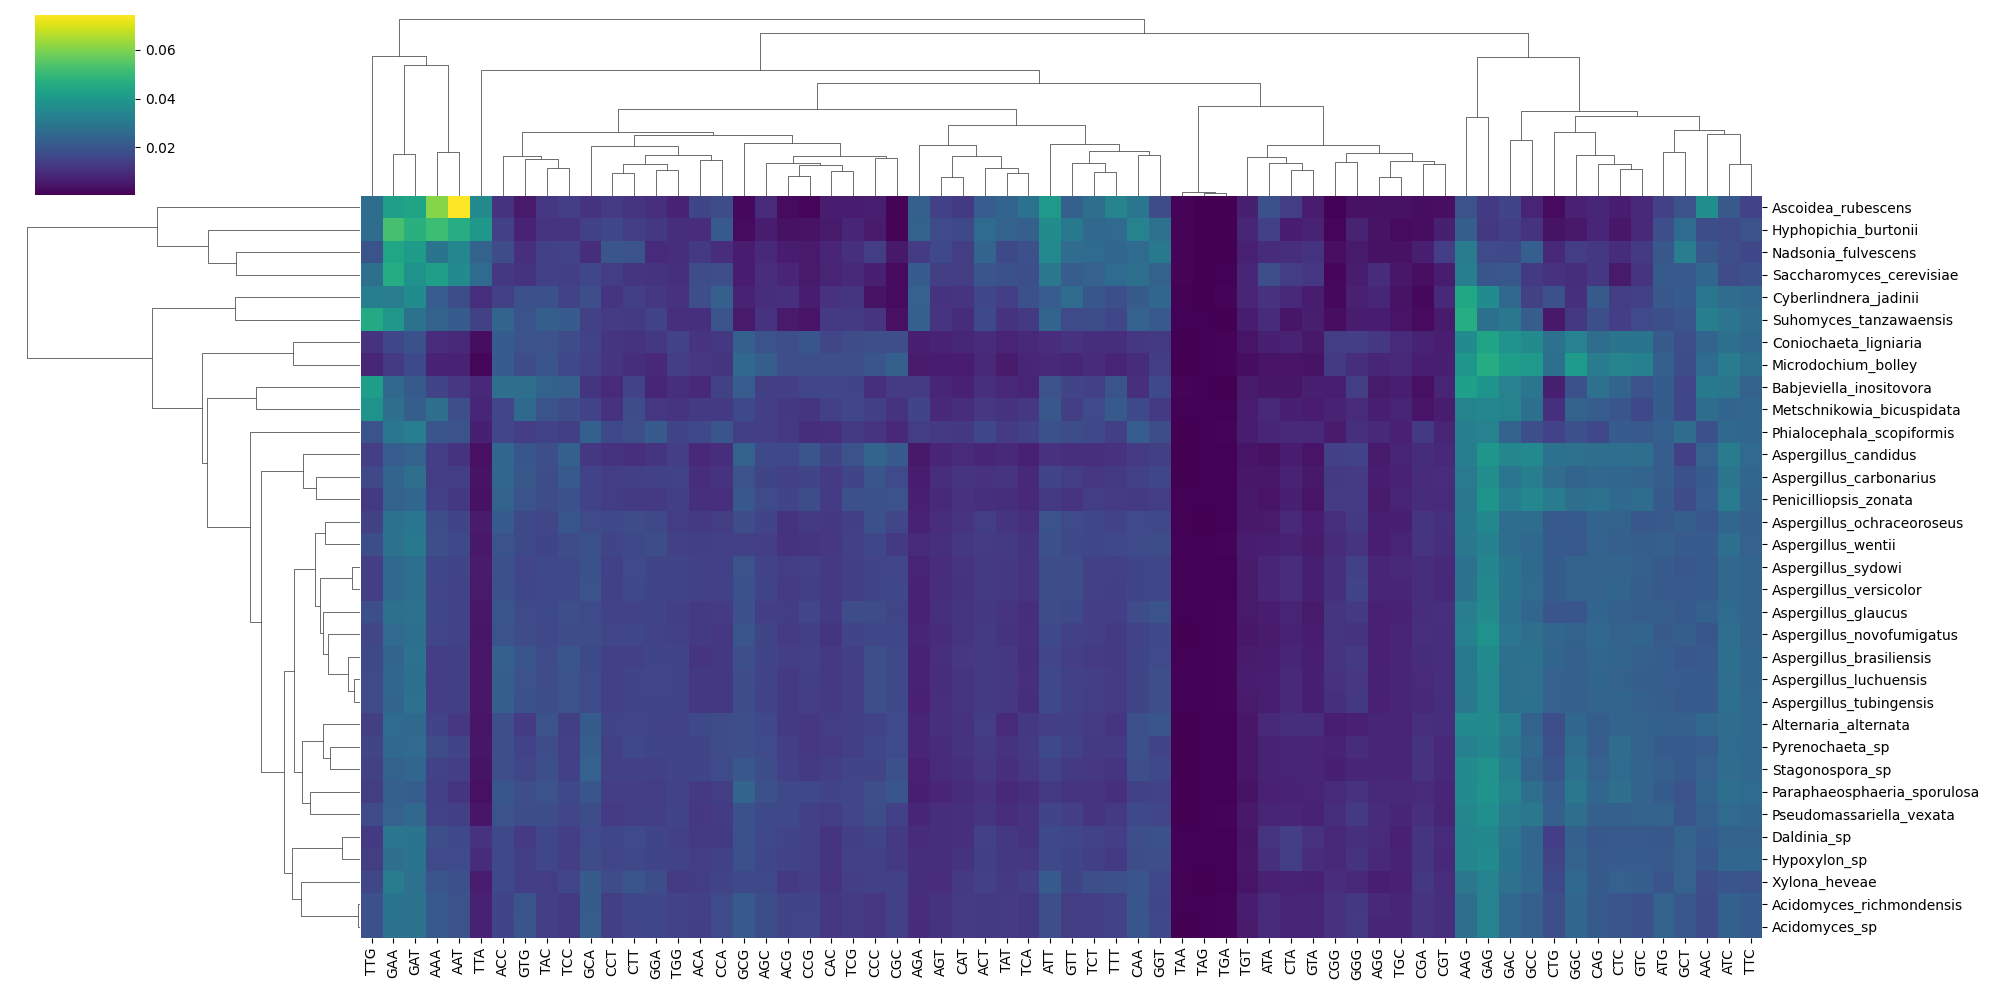

In [22]:
CodonsDict = {
        'TTT': 0, 'TTC': 0, 'TTA': 0, 'TTG': 0, 'CTT': 0,
        'CTC': 0, 'CTA': 0, 'CTG': 0, 'ATT': 0, 'ATC': 0,
        'ATA': 0, 'ATG': 0, 'GTT': 0, 'GTC': 0, 'GTA': 0,
        'GTG': 0, 'TAT': 0, 'TAC': 0, 'TAA': 0, 'TAG': 0,
        'CAT': 0, 'CAC': 0, 'CAA': 0, 'CAG': 0, 'AAT': 0,
        'AAC': 0, 'AAA': 0, 'AAG': 0, 'GAT': 0, 'GAC': 0,
        'GAA': 0, 'GAG': 0, 'TCT': 0, 'TCC': 0, 'TCA': 0,
        'TCG': 0, 'CCT': 0, 'CCC': 0, 'CCA': 0, 'CCG': 0,
        'ACT': 0, 'ACC': 0, 'ACA': 0, 'ACG': 0, 'GCT': 0,
        'GCC': 0, 'GCA': 0, 'GCG': 0, 'TGT': 0, 'TGC': 0,
        'TGA': 0, 'TGG': 0, 'CGT': 0, 'CGC': 0, 'CGA': 0,
        'CGG': 0, 'AGT': 0, 'AGC': 0, 'AGA': 0, 'AGG': 0,
        'GGT': 0, 'GGC': 0, 'GGA': 0, 'GGG': 0}
codon_freq_matrix = []

for orf_df in all_orf_seqs:
    # Sum codon frequencies for all coding sequences in the species DataFrame
    species_codon_frequencies = np.sum([count_codons(seq) for seq in orf_df['coding']], axis=0)
    # Normalize by total to get frequencies
    species_codon_frequencies = species_codon_frequencies / np.sum(species_codon_frequencies)
    # Add to the matrix
    codon_freq_matrix.append(species_codon_frequencies)

# Step 2: Convert the matrix to a DataFrame
codon_freq_df = pd.DataFrame(codon_freq_matrix, index=species_names, columns=sorted(CodonsDict.keys()))

# Check if all species are included
assert len(codon_freq_df) == 33, "Not all species are included in the DataFrame."

# Plot a heatmap with all species and codons

plt.figure(figsize=(20, 10))
sns.clustermap(codon_freq_df, cmap="viridis", figsize=(20, 10), method='average', metric='euclidean')
plt.show()

In [23]:

data_directory = 'species_GFP_predictions'
data_for_df = []

for species_file in os.listdir(data_directory):
    if species_file.endswith('.npy'):  # Ensure we're only processing .npy files
        # Remove '_GFP_predictions' from the species name while extracting it
        species_name = species_file.replace('.npy', '').replace('_GFP_predictions', '')
        file_path = os.path.join(data_directory, species_file)
        
        # Load the GFP predictions from the .npy file
        gfp_predictions = np.load(file_path)
        
        # Calculate median and average
        median_value = np.median(gfp_predictions)
        average_value = np.mean(gfp_predictions)
        
        # Append the data for this species to the list
        data_for_df.append({'Species': species_name, 'Median': median_value, 'Average': average_value})

# Create a DataFrame from the list
df = pd.DataFrame(data_for_df)

# Sort the DataFrame alphabetically by the 'Species' column
df_sorted = df.sort_values(by=['Median', 'Average'], ascending=[False, False]).reset_index(drop=True)

# Display the DataFrame
print(df_sorted)


                        Species     Median    Average
0           Nadsonia_fulvescens  17.090698  17.244429
1          Hyphopichia_burtonii  16.961182  17.073118
2           Microdochium_bolley  16.933460  16.980917
3            Ascoidea_rubescens  16.891531  16.910820
4         Penicilliopsis_zonata  16.600794  16.652893
5      Saccharomyces_cerevisiae  16.584286  16.257671
6         Cyberlindnera_jadinii  16.545479  16.553566
7       Babjeviella_inositovora  16.493046  16.550085
8        Aspergillus_versicolor  16.488342  16.494446
9    Aspergillus_ochraceoroseus  16.438604  16.501410
10              Stagonospora_sp  16.393078  16.388025
11           Aspergillus_sydowi  16.389725  16.405890
12          Aspergillus_glaucus  16.378618  16.406641
13  Paraphaeosphaeria_sporulosa  16.369270  16.392620
14     Aspergillus_brasiliensis  16.344507  16.339775
15           Aspergillus_wentii  16.298210  16.320528
16         Aspergillus_candidus  16.296368  16.260946
17       Aspergillus_luchuen

In [25]:


data_directory = 'species_GFP_predictions'  
species_gfp_predictions = {}

# Load data into the dictionary
for species_file in os.listdir(data_directory):
    if species_file.endswith('.npy'):
        species_name = species_file.replace('.npy', '').replace('_GFP_predictions', '')
        file_path = os.path.join(data_directory, species_file)
        species_gfp_predictions[species_name] = np.load(file_path)

# Container for test results
test_results = []

# Saccharomyces cerevisiae comparisons
Saccharomyces_predictions = species_gfp_predictions['Saccharomyces_cerevisiae']

for species, predictions in species_gfp_predictions.items():
    if species != 'Saccharomyces_cerevisiae':  # Exclude comparison with itself
       
        stat, p_value = mannwhitneyu(Saccharomyces_predictions, predictions, alternative='two-sided').statistic, mannwhitneyu(Saccharomyces_predictions, predictions, alternative='two-sided').pvalue
        test_results.append((species, stat, p_value))

# Sort results by p-value for convenience
test_results.sort(key=lambda x: x[2])

# Number of comparisons
n_comparisons = len(test_results)

# Apply Bonferroni correction
corrected_results = [(species, stat, p_value * n_comparisons) for species, stat, p_value in test_results]

# Adjust corrected p-values to not exceed 1
corrected_results = [(species, stat, min(p_value_corrected, 1)) for species, stat, p_value_corrected in corrected_results]

# Display corrected results
for species, stat, p_value_corrected in corrected_results:
    print(f"Comparison with {species}: Statistic = {stat}, Corrected P-value = {p_value_corrected}")


Comparison with Aspergillus_carbonarius: Statistic = [24738702.], Corrected P-value = [4.28549067e-244]
Comparison with Hypoxylon_sp: Statistic = [18794110.], Corrected P-value = [1.75605742e-133]
Comparison with Pseudomassariella_vexata: Statistic = [17138238.], Corrected P-value = [3.3225432e-113]
Comparison with Daldinia_sp: Statistic = [18815225.5], Corrected P-value = [5.99108383e-107]
Comparison with Nadsonia_fulvescens: Statistic = [4186786.], Corrected P-value = [2.58041793e-102]
Comparison with Alternaria_alternata: Statistic = [23700929.], Corrected P-value = [3.5374798e-99]
Comparison with Coniochaeta_ligniaria: Statistic = [21288089.], Corrected P-value = [1.29008954e-97]
Comparison with Phialocephala_scopiformis: Statistic = [30182877.], Corrected P-value = [2.26550242e-94]
Comparison with Microdochium_bolley: Statistic = [14856471.], Corrected P-value = [2.42921951e-76]
Comparison with Hyphopichia_burtonii: Statistic = [4943664.5], Corrected P-value = [1.21222465e-63]
Com

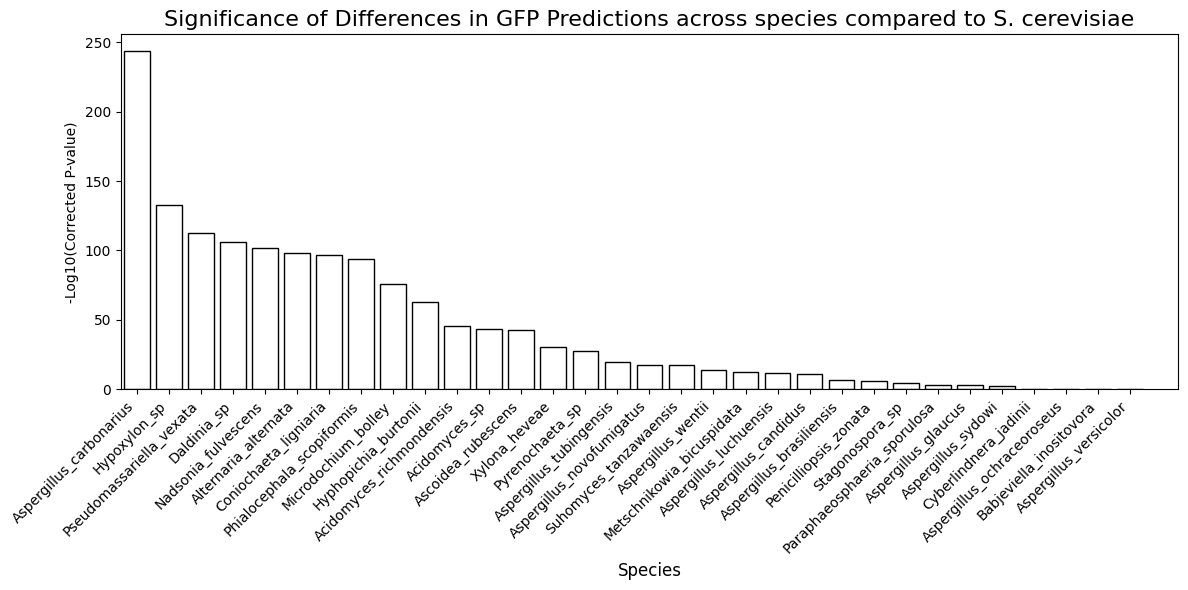

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming corrected_results is already correctly prepared
species = [result[0] for result in corrected_results]
# Calculate -log10(p) only for p-values <= 0.05, set others to 0
neg_log_p_values = [-np.log10(result[2] if np.isscalar(result[2]) else result[2][0]) if result[2] > 0 and result[2] <= 0.05 else 0 for result in corrected_results]

plt.figure(figsize=(12, 6))
plt.bar(range(len(species)), neg_log_p_values, color='white', edgecolor='black')
plt.xticks(range(len(species)), species, rotation=45, ha='right', fontsize=10)
plt.xlabel('Species', fontsize=12)
plt.ylabel('-Log10(Corrected P-value)')
plt.title('Significance of Differences in GFP Predictions across species compared to S. cerevisiae', fontsize=16)
plt.xlim([-0.5, len(species_names)-0.5])  
plt.tight_layout()
plt.show()



In [27]:
top_10_gfp_predictions = {}

for species in species_names:
    # Retrieve the list of predictions for the current species
    predictions = species_gfp_predictions[species]
    
    # Sort the predictions in descending order and select the top 10
    top_10_indices = sorted(range(len(predictions)), key=lambda i: predictions[i], reverse=True)[:10]
    top_10_values = [predictions[i] for i in top_10_indices]
    
    # Store the top 10 predictions and their indices in the new dictionary
    top_10_gfp_predictions[species] = {'values': top_10_values, 'indices': top_10_indices}

data_for_df = []

for species in species_names:
    predictions_data = top_10_gfp_predictions[species]
    species_data = {'Species': species}
    species_data.update({f'Top {i+1}_Value': predictions_data['values'][i] for i in range(len(predictions_data['values']))})
    species_data.update({f'Top {i+1}_Index': predictions_data['indices'][i] for i in range(len(predictions_data['indices']))})
    data_for_df.append(species_data)

# Create a DataFrame from the list
df_predictions = pd.DataFrame(data_for_df)

# Sort the DataFrame alphabetically by the 'Species' column
df_predictions_sorted = df_predictions.sort_values(by='Species').reset_index(drop=True)

# Display the sorted DataFrame
print(df_predictions_sorted)


                        Species  Top 1_Value  Top 2_Value  Top 3_Value  \
0      Acidomyces_richmondensis   [21.24165]  [21.094597]  [21.070848]   
1                 Acidomyces_sp   [21.24165]  [21.094597]  [21.070848]   
2          Alternaria_alternata  [22.255308]  [22.230278]  [20.917334]   
3            Ascoidea_rubescens  [22.343225]  [22.150629]  [21.519857]   
4      Aspergillus_brasiliensis  [22.472702]  [21.932611]  [20.592054]   
5          Aspergillus_candidus  [23.020956]  [22.279362]  [21.849611]   
6       Aspergillus_carbonarius  [211.56946]  [152.45836]  [152.45836]   
7           Aspergillus_glaucus  [22.895983]   [22.39741]  [22.237223]   
8        Aspergillus_luchuensis  [25.087542]  [22.315834]   [21.35216]   
9     Aspergillus_novofumigatus  [21.783216]   [21.75526]   [21.71739]   
10   Aspergillus_ochraceoroseus  [25.551466]  [25.383196]   [24.14105]   
11           Aspergillus_sydowi   [27.60666]   [21.64741]  [21.524668]   
12      Aspergillus_tubingensis  [24.7

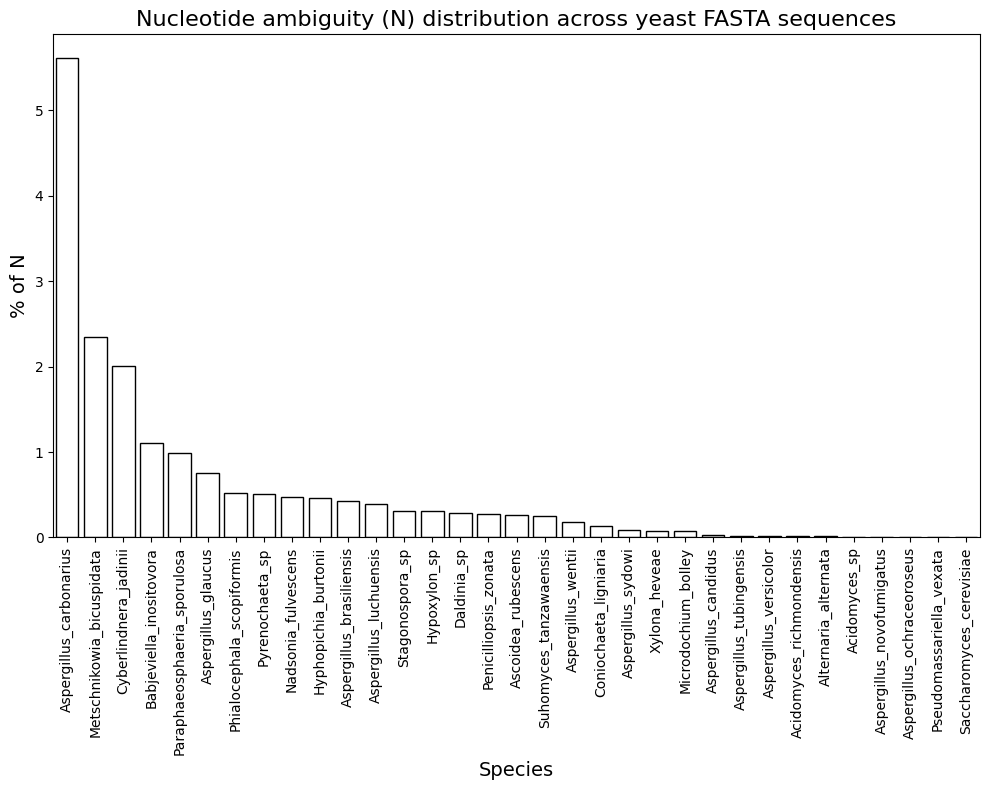

In [29]:

def analyse_fasta_quality(fasta_file):
    total_length = 0
    total_n = 0
    gc_count = 0

    for record in SeqIO.parse(fasta_file, "fasta"):
        seq = record.seq
        total_length += len(seq)
        total_n += seq.count('N') + seq.count('n')
        gc_count += seq.count('G') + seq.count('g') + seq.count('C') + seq.count('c')

    n_percentage = (total_n / total_length) * 100 if total_length else 0
    gc_content = (gc_count / total_length) * 100 if total_length else 0

    return total_length, n_percentage, gc_content

fasta_folder = 'Dataset_Assembly/fasta/'
n_percentages = []  # Store percentage of 'N's
species_for_plot = []  # Store species names for plotting

for fasta_file in sorted(os.listdir(fasta_folder)):  # Sort to maintain order
    if fasta_file.endswith('.fa'):
        species_name_base = fasta_file.replace('.fa', '')
        species_for_plot.append(species_name_base)  # Use file name without '.fa' for plot

        # Call the function without species_name
        total_length, n_percentage, gc_content = analyse_fasta_quality(os.path.join(fasta_folder, fasta_file))
        n_percentages.append(n_percentage)

# Sort the species and N percentages by N percentage in descending order
sorted_data = sorted(zip(species_for_plot, n_percentages), key=lambda x: x[1], reverse=True)
sorted_species, sorted_n_percentages = zip(*sorted_data)

# Plotting
plt.figure(figsize=(10, 8))  
plt.bar(sorted_species, sorted_n_percentages, color='white', edgecolor='black')
plt.xlabel('Species', fontsize=14)
plt.ylabel('% of N', fontsize=14)
plt.xticks(rotation=90)  
plt.title('Nucleotide ambiguity (N) distribution across yeast FASTA sequences', fontsize=16)
plt.xlim([-0.5, len(sorted_species)-0.5])
plt.tight_layout()  
plt.show()
